<div style="text-align: center;">
    <h2><strong>ERROR DETECTION, RECURSIVE ANALYSIS AND NETWORK ANALYSIS OF CHROMATOGRAPHY DATABASE CALCULATIONS</strong></h2>
    <h2>Data Science 200 Final Project<h2>
    <h2>Ash Baghai<h2>
    <h2>August, 2024<h2>
</div>


**Description**: 

This program is designed to analyze a specific, tab delimited summary file from a chromatography database system called Empower.
The file, "CF_Data_File_Project2.txt", contains information on all formulas used by the software to generate calculations for Liquid Chromatography Analysis. These calculations are called custom fields.

The summary file in this project is not proprietary and does not contain information related to private intellectual property.

The objective of this program is to detect any errors within custom fields and to quantify relationships among them as they reference each other in their formulas.

This will ultimately help facilitate the correction, maintenance, and update of such custom fields to remediate any errors and to address new scientific and regulatory requirements for drug analysis.



# STEP 1 - Read & format the data

In [155]:
import pandas as pd 
import numpy as np

from IPython.display import display
import re
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import sys


# Print versions of the libraries
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")

print(f"seaborn version: {sns.__version__}")
print(f"networkx version: {nx.__version__}")
print(f"re module version: {re.__version__ if hasattr(re, '__version__') else 'builtin module, no version'}")
print(f"Python version: {sys.version}")

pandas version: 2.2.2
numpy version: 2.0.1
seaborn version: 0.13.2
networkx version: 3.3
re module version: 2.2.1
Python version: 3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)]


**Python and Module Version info:**  

pandas version: 2.2.2  
numpy version: 2.0.1  
seaborn version: 0.13.2  
networkx version: 3.3  
re module version: 2.2.1  
Python version: 3.12.5   
(tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)]


In [156]:

from eda_formatting import edaf


"""Reading the Data"""
df =pd.read_csv('CF_Data_File_Project2.txt', sep='\t')
df.head
#edaf(df.head(2)).table_format() # confirmation of the data read


"""Improving the data formatting for better readability and dropping non essential columns"""
#update the name column to something more descriptive
df.rename(columns={'Name': 'CustomFieldName'}, inplace=True)

#reformat the columns using edaf column formatting function
df.columns = edaf(df).column_format().columns # note: the '#' column name changes to 'num'

#drop the 'num column
df.drop('num', axis=1, inplace=True)

#confirmation of dataframe formatting
edaf(df.head(2)).table_format()


,project_name,customfieldname,field_type,type,source,formula,cfield_id
0,20XX_Q3\GxP_20XX_Q3\WC_20XX_Q3\ZY8122_20XX_Q3,ABS_Assay_Diff,Peak,Real (0.0),Calculated,(SAME.%..MAX(Weight_Percent_As_Is))-(SAME.%..MIN(Weight_Percent_As_Is)),100
1,20XX_Q3\GxP_20XX_Q3\WC_20XX_Q3\ZY8122_20XX_Q3,Abs_PctArea_Diff,Peak,Real (0.0),Calculated,((SAME.%..MAX(Area))-(SAME.%..MIN(Area)))/(((SAME.%..MAX(Area))+(SAME.%..MIN(Area)))/2)*100,101


# **Step 2: Understand the Structure of the Data**

In [157]:


# Basic information about the dataset
print(df.info())  #note: customfieldname and formula are the primary columns of interest

print(f"\nCount unique occurrences of all data fields of interest:\n")
# Display summary for unique occurrence of values for object and categorical columns values
display(edaf(pd.DataFrame(df.describe(include=['object', 'category']).loc[['count', 'unique']])).table_format())

print(f"\nCount unique occurrences of  data fields of interest with populated formulas:\n")
# # Display summary for unique occurrence of values for object and categorical columns values without empty formula values
display(edaf(pd.DataFrame(df.dropna(subset=['formula']).describe(include=['object', 'category']).loc[['count', 'unique']])).table_format())
#note: the mismatch of unique custom field names and formulas is an indication of a potential data quality issue

# reconfirmation of empty values for unique combinations of columns 1 to 5
#any empty formula field is evaluated for the type of data source that corresponds to it; where "Keyboard" values are expected
# Extract the relevant columns and drop duplicates
df_unique = df.iloc[:, 1:6].drop_duplicates()

# Identify rows where "formula" is null
null_formula_rows = df_unique[df_unique['formula'].isnull()]

# Collect corresponding "source" values
source_values = null_formula_rows['source'].tolist()

# Count the number of null values in the "formula" column
null_count = null_formula_rows['formula'].isnull().sum()

# Create a new DataFrame with the sum of null values and concatenated "source" values
null_sum_df = pd.DataFrame({
    'formula': [null_count],
    'source': [', '.join(source_values)]
})
print(f"Missing formula values and corresponding source values. \n")
display(edaf(null_sum_df).table_format()) 

#let's check the names of  any Calculated source values with empty formulas 
# Filter rows where "formula" is null and "source" is "Calculated"
filtered_df = df_unique[df_unique['formula'].isnull() & (df_unique['source'] == 'Calculated')]
print(f"Missing formula values and corresponding to calculated source values. \n")
# Display the filtered DataFrame
display(edaf(filtered_df).table_format())

# Display the unique values in each column for the columns of interest

# Create an empty dictionary to store unique values for each column
unique_values_dict = {}
# Iterate through each column in the original DataFrame, dropping non-essential column, cfield_id
for column in df.columns:
    if column != 'cfield_id':
        unique_values_dict[column] = df[column].unique()

# Convert the dictionary to a new DataFrame
unique_values_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in unique_values_dict.items()]))

# Rename all columns by adding the prefix "unique"
unique_values_df = unique_values_df.add_prefix('unique_')

# Replace NaN values with empty strings
unique_values_df = unique_values_df.fillna('')

print(f"\nA listing of all unique values in each column:")
# Display the new DataFrame
display(edaf(unique_values_df).table_format())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2883 entries, 0 to 2882
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   project_name     2883 non-null   object
 1   customfieldname  2883 non-null   object
 2   field_type       2883 non-null   object
 3   type             2883 non-null   object
 4   source           2883 non-null   object
 5   formula          1403 non-null   object
 6   cfield_id        2883 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 157.8+ KB
None

Count unique occurrences of all data fields of interest:



,project_name,customfieldname,field_type,type,source,formula
count,2883,2883,2883,2883,2883,1403
unique,40,74,5,4,2,36



Count unique occurrences of  data fields of interest with populated formulas:



,project_name,customfieldname,field_type,type,source,formula
count,1403,1403,1403,1403,1403,1403
unique,40,37,2,3,1,36


Missing formula values and corresponding source values. 



,formula,source
0,37,"Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Keyboard, Calculated, Calculated, Keyboard"


Missing formula values and corresponding to calculated source values. 



,customfieldname,field_type,type,source,formula
62,Validation Result Pass/Fail,Result,Enum,Calculated,NaN
63,Validation Study Pass/Fail,Result,Enum,Calculated,NaN



A listing of all unique values in each column:


,unique_project_name,unique_customfieldname,unique_field_type,unique_type,unique_source,unique_formula
0,20XX_Q3\GxP_20XX_Q3\WC_20XX_Q3\ZY8122_20XX_Q3,ABS_Assay_Diff,Peak,Real (0.0),Calculated,(SAME.%..MAX(Weight_Percent_As_Is))-(SAME.%..MIN(Weight_Percent_As_Is))
1,20XX_Q3\GxP_20XX_Q3\WC_20XX_Q3\ZY1117_20XX_Q3,Abs_PctArea_Diff,Sample,Text,Keyboard,((SAME.%..MAX(Area))-(SAME.%..MIN(Area)))/(((SAME.%..MAX(Area))+(SAME.%..MIN(Area)))/2)*100
2,20XX_Q3\GxP_20XX_Q3\WC_20XX_Q3\ZY5231_20XX_Q3,AdditionalInformation,Sample Set,Enum,,
3,20XX_Q3\GxP_20XX_Q3\WC_20XX_Q3\ZY8577_20XX_Q3,AR_Sensitivity,Component,Boolean,,SN0103.1.(Response)*Dilution/SS0101.1.(Response)
4,20XX_Q3\GxP_20XX_Q3\WC_20XX_Q3\ZY2619_20XX_Q3,AVE_CorrectedAN,Result,,,SAME.%..AVE(CorrectedAN)
5,20XX_Q3\GxP_20XX_Q3\WC_20XX_Q3\ZY3500_20XX_Q3,Avg_RT,,,,SAME.%.SAME.AVE(Retention Time)
6,20XX_Q3\GxP_20XX_Q3\WC_20XX_Q3\ZY8387_20XX_Q3,CA,,,,"Area*REPLACE(CConst1,1)"
7,20XX_Q3\GxP_20XX_Q3\WC_20XX_Q3\ZY1699_20XX_Q3,CalWts,,,,Dilution*Amount/SampleWeight
8,20XX_Q3\GxP_20XX_Q3\WC_20XX_Q3\ZY5510_20XX_Q3,CF,,,,"REPLACE(CConst2, 1)"
9,20XX_Q3\GxP_20XX_Q3\WC_20XX_Q3\ZY7859_1234_20XX_Q3,Column Name,,,,"100*CA/REPLACE(CCompRef2[CA],TotalCA)"


#### **Outputting tables to html**
**Note: it is commented out to prevent outputting to file during grading**

In [171]:
# #outputting my summaries to html, commenting out to prevent overwriting the file
# import io



# # Convert DataFrames to HTML
# html_output = f"""
# <html>
# <head><title>Step 2: Data Structure Analysis</title></head>
# <body>
# <h1>Step 2: Data Structure Analysis</h1>
# <h2>Summary for unique occurrence of values</h2>
# {edaf(pd.DataFrame(df.describe(include=['object', 'category']).loc[['count', 'unique']])).table_format().to_html()}
# <h2>Summary for unique occurrence of values without empty formula values</h2>
# {edaf(pd.DataFrame(df.dropna(subset=['formula']).describe(include=['object', 'category']).loc[['count', 'unique']])).table_format().to_html()}
# <h2>Missing formula values and corresponding source values</h2>
# {edaf(null_sum_df).table_format().to_html()}
# <h2>Custom fields with missing formula values with "Calculated" source values</h2>
# {edaf(filtered_df).table_format().to_html()}
# <h2>Listing of all unique values in each data column</h2>
# {edaf(unique_values_df).table_format().to_html()}
# </body>
# </html>
# """

# # Write the HTML content to a file
# with open('ABaghai_DS200_Final_Stp_1_2.html', 'w') as f:
#     f.write(html_output)

## **Step 3 Data Error Detection**
#### Custom field and formula typo and duplicate detection

In [159]:
"""CUSTOM FIELD ERROR DETECTION: let's determine which formulas have custom field name variants"""
# Group by the 'formula' column and filter groups with more than one unique 'customfieldname'
shared_formulas = df.groupby('formula').filter(lambda x: x['customfieldname'].nunique() > 1)
#obtain the unique formulas with multiple custom field names
unique_shared_form = shared_formulas['formula'].unique()

# Initialize an empty dictionary to store the formula and its associated custom field names
duplicate_cf_dict = {}

# Iterate over each unique formula in the filtered DataFrame & add its corresponding custom field names to the dictionary
for formula in unique_shared_form:
    # Get the custom field names associated with the current formula
    custom_fields = shared_formulas[shared_formulas['formula'] == formula]['customfieldname'].unique()
    
    # Add the formula and its associated custom field names to the dictionary
    duplicate_cf_dict[formula] = custom_fields.tolist()

#typecase the dictionary to a dataframe for better presentation
dup_cf_df = pd.DataFrame(duplicate_cf_dict).T
#adding an index and column titles to the dataframe
dup_cf_df.index.name ='formula'
dup_cf_df.columns =  [f'customfieldname {i+1}' for i, col in enumerate(dup_cf_df.columns)]

#boolean conditions to evaluate formulas with multiple representations across custom fields
if len(duplicate_cf_dict) == 0:
    print(f'There are no naming variants found for the custom field formulas.\n')
    
elif len(duplicate_cf_dict) == 1:
    print(f'There is {len(duplicate_cf_dict )} unique formula that has multiple custom field name variants.\n') 
    print(f'The custom field name variants and their formula are:\n')
    display(edaf(dup_cf_df).table_format())
    
else:
    print(f'There are {len(duplicate_cf_dict )}  unique formulas that have multiple custom field name variants.') 
    print(f'The custom field name variants and their formulas are:\n')
    display(edaf(dup_cf_df).table_format())
    
"""FORMULA ERROR DETECTION: let's determine if a given custom field has variations int its formula across projects. """
#boolean conditions to evaluate a unique, given custom field name that appears with different formulas
mult_form_by_cf= df.groupby('customfieldname').filter(lambda x: x['formula'].nunique() > 1)
#generate a dataframe with unique custom field name 
mult_cf_name = mult_form_by_cf['customfieldname'].unique()

diff_form_cf_dict = {}
# Iterate over each unique custom fields in the filtered dataframe
for c_field in mult_cf_name :
    # Get the formula associated with the current custom field
    form_val = mult_form_by_cf[mult_form_by_cf['customfieldname'] == c_field]['formula'].unique()
    
    # Add the customfield and its associated formula variants to the dictionary
    diff_form_cf_dict[c_field] =form_val.tolist()
    
#typecase the dictionary to a dataframe for better presentation    
mult_form_df = pd.DataFrame(diff_form_cf_dict).T
#typecase the dictionary to a dataframe for better presentation
mult_form_df.index.name ='customfieldname'
mult_form_df.columns =  [f'formula {i+1}' for i, col in enumerate(mult_form_df.columns)]   

#boolean conditions to evaluate custom fields with multiple formula variants
if len(diff_form_cf_dict) == 0:
    print(f'There is no duplication of formulas between custom fields.\n')
    
elif len(diff_form_cf_dict) == 1:
    print(f'There is {len(diff_form_cf_dict)} unique custom field that is associated with multiple formulas.\n')
    print(f'This could be an indication that the custom field name is being used with different formulas, possibly due to errors or variants.\n')
    print(f'The formulas that are associated with the custom field are:\n')
    display(edaf(mult_form_df).table_format())
    
else:
    print(f'There are {len(diff_form_cf_dict)} unique custom fields that are associated with multiple formulas.\n')
    print(f'This could be an indication that the custom field names are being used with different formulas, possibly due to errors or variants.\n')
    print(f'The custom fields that share the same formulas are:\n')
    display(edaf(mult_form_df).table_format())
    
    

There are 2  unique formulas that have multiple custom field name variants.
The custom field name variants and their formulas are:



,customfieldname 1,customfieldname 2
formula,,
"REPLACE(Corr_Dis_Amt/Dissolution Claimed Amount*100,-60000)",Percent_Dissolved,Per_Dissolved
(S0102.%..AVE(Response)/S0102.%..AVE(CalWts))/(S?0101.%..AVE(Response)/S?0101.%..AVE(CalWts))*100,Standard_Recovery_Ninj,Standard_Recovery_Inj


There is 1 unique custom field that is associated with multiple formulas.

This could be an indication that the custom field name is being used with different formulas, possibly due to errors or variants.

The formulas that are associated with the custom field are:



,formula 1,formula 2
customfieldname,,
OVI_ppm,Weight_Percent_OVI*10000,Weight_Percent_OVI*Cconst3


#### **Outputting tables to html**
**Note: it is commented out to prevent outputting to file during grading**

In [160]:
# # Convert DataFrames to HTML, commenting out to prevent overwriting the file
# html_output = f"""
# <html>
# <head><title>Step 3: Data Error Detection</title></head>
# <body>
# <h1>Step 3: Data Error Detection</h1>
# <h2>Formulas with Multiple Custom Field Names</h2>
# {edaf(dup_cf_df).table_format().to_html()}
# <h2>Custom Fields with Multiple Formulas</h2>
# {edaf(mult_form_df).table_format().to_html()}
# </body>
# </html>
# """

# # Write the HTML content to a file
# with open('ABaghai_DS200_Final_Stp_3.html', 'w') as f:
#     f.write(html_output)

# **Step 4: Data Cleaning based on Error Detection**

#### Note: for the purposes of expedience the error detection uses  pre-evaluated erroneous typos and duplications identified from the testing above. 

#### An additional out of scope feature would be to have a user input selection for removal of the type of data and its duplicate or erroneous form from the dataframe based on the results from the above, step 3, analysis.

In [161]:
#The above summaries will be used to make any necessary corrections to the Empower databse's custom fields 
# Let's now remove the undesired dataframe entries the tables above corresponding to customfieldname 2 and formula 2.

# Get the index positions for the entries to be removed
cf1_index_to_remove = df[df['customfieldname'] == dup_cf_df.iloc[0, 1]].index.tolist()
cf2_index_to_remove = df[df['customfieldname'] == dup_cf_df.iloc[1, 1]].index.tolist()
form_index_to_remove = df[df['formula'] == mult_form_df.iloc[0, 1]].index.tolist()

# Combine the index positions into a single list
all_indices_to_remove = cf1_index_to_remove + cf2_index_to_remove + form_index_to_remove


df_clean = df.drop(all_indices_to_remove)
# #code confirming dropped values
# edaf(df_clean.tail(4)).table_format()

# **Step 5: Analyze relationships within the Data**



#### Custom Field Reference Count Analysis

In [162]:
"""DETERMINING THE CUSTOM FIELDS THAT ARE REFERENCED MOST BY OTHER CUSTOM FIELDS BY DOING A RECURSIVE ANALYSIS 
OF CUSTOM FIELD FORMULAS."""

# Recursive function to count custom field references
def rec_count_ref(formula, field, unique_combinations_df):
    if not isinstance(formula, str):
        return 0
    count = 0
    if re.search(r'\b' + re.escape(field) + r'\b', formula):
        matches = re.findall(r'\b' + re.escape(field) + r'\b', formula)
        count = len(matches)
  
    for other_field in unique_combinations_df['customfieldname']:
        if other_field != field and re.search(r'\b' + re.escape(other_field) + r'\b', formula):
            nested_formula_series = unique_combinations_df[unique_combinations_df['customfieldname'] == other_field]['formula']
            if not nested_formula_series.empty:
                nested_formula = nested_formula_series.values[0]
                count += rec_count_ref(nested_formula, field, unique_combinations_df)
    return count


# Drop duplicates based on the specified columns
unique_combinations_df= df_clean.drop_duplicates(subset=['customfieldname','field_type', 'type', 'source', 'formula'])


# Create a Series to store the reference counts
reference_counts = pd.Series(0, index=unique_combinations_df['customfieldname'])

# Iterate over each unique custom field name to count the references; this involves a call to the recursive count
for field in reference_counts.index:

    reference_counts[field] = unique_combinations_df['formula'].apply(lambda x: rec_count_ref(x, field, unique_combinations_df)).sum()


# Drop zero value counts and sort in descending order
reference_counts = reference_counts[reference_counts > 0].sort_values(ascending=False)

# Convert the Series to a DataFrame for better readability
reference_counts_df = reference_counts.reset_index()
reference_counts_df.columns = ['customfieldname', 'reference_count']


print(f'Number of times particular custom fields are referenced directly and recursively in custom field formulas:')
display(edaf(reference_counts_df).table_format()) 

Number of times particular custom fields are referenced directly and recursively in custom field formulas:


,customfieldname,reference_count
0,CA,8
1,Label_Claim,6
2,Sys_Suit,6
3,Dilution,5
4,CalWts,4
5,Residual_Solvent,3
6,WaterContent,3
7,SampleWeight,3
8,Other_Impurity,3
9,Weight_Percent_As_Is,2


#### Custom Field Dependency Listing

In [163]:

"""LISTING ALL CUSTOM FIELDS THAT A GIVEN CUSTOM  FIELD DEPENDS ON (DIRECTLY & RECURSIVELY) IN ITS FORMULA
Note: this does not reveal the number of times a custom field references another, only that is does."""
#IMPORTANT NOTE: on variable dependency, the "unique_combinations_df" variable from the previous code block is used here.
# Recursive function to collect referenced fields
def rec_collect_references(formula, input_df):
    if not isinstance(formula, str):
        return []
    referenced_fields = []
    for other_field in input_df['customfieldname']:
        if re.search(r'\b' + re.escape(other_field) + r'\b', formula):
        #if other_field in formula:
            #print(formula)
            nested_formula = input_df[input_df['customfieldname'] == other_field]['formula'].values
            if nested_formula.size > 0:
                nested_references = rec_collect_references(nested_formula[0], input_df)
                referenced_fields.append(other_field)
                referenced_fields.extend(nested_references)
    return list(set(referenced_fields))

# Create a DataFrame to store the reference names
reference_names = pd.DataFrame(index=unique_combinations_df['customfieldname'], columns=['references'])


# Iterate over each unique custom field name to collect referenced fields
for field in reference_names.index:
    formula = unique_combinations_df[unique_combinations_df['customfieldname'] == field]['formula'].values
    if formula.size > 0:
        references = rec_collect_references(formula[0], unique_combinations_df)
        reference_names.at[field, 'references'] = references

# Add a title to the index
reference_names.index.name = 'Custom Field Name'
     
# Drop rows with NaN values
reference_names.dropna(inplace=True)

# Drop rows with empty lists
reference_names = reference_names[reference_names['references'].map(lambda x: len(x) > 0)]

print(f'Custom field names that are referenced directly and recursively in custom field formulas:')
edaf(reference_names).table_format()

Custom field names that are referenced directly and recursively in custom field formulas:


,references
Custom Field Name,
ABS_Assay_Diff,"['Label_Claim', 'Weight_Percent_As_Is']"
AR_Sensitivity,['Dilution']
AVE_CorrectedAN,"['CA', 'TotalCA', 'CorrectedAN']"
CalWts,"['Dilution', 'SampleWeight']"
CorrectedAN,"['TotalCA', 'CA']"
LIMS_TRANSFER_ATTRIBUTE,['xPeakTransfer']
OVI,"['Other_Impurity', 'Residual_Solvent']"
OVI_ppm,['Weight_Percent_OVI']
Percent_Assay_Difference,"['Label_Claim', 'Other_Impurity', 'WaterContent', 'OVI', 'Residual_Solvent', 'Weight_Percent_Dry']"


In [172]:
# #Convert DataFrames to HTML, commenting out to prevent overwriting the file
# html_output = f"""
# <html>
# <head><title>Step 5 - Recursive Analysis: Referenced Custom Field Names</title></head>
# <body>
# <h1>Step 5 - Recursive Analysis: Referenced Custom Field Names</h1>
# <h2>Recursive and Direct Custom Field Reference Counts</h2>
# {edaf(reference_counts_df).table_format().to_html()}
# <h2>Recursive and Direct Custom Field Dependencies</h2>
# {edaf(reference_names).table_format().to_html()}
# </body>
# </html>
# """

# # Write the HTML content to a file
# with open('ABaghai_DS200_Final_Stp_5.html', 'w') as f:
#     f.write(html_output)

# **Step 7: Visualize Relationships**




#### **Part 1: Reference Count Analysis Plot**

Objective: 

use bar plot to visualize custom field that is the most referenced directly and recursively in custom field formulas

Implementation: 
- colormetric bar plot using prior reference count analysis
- 
Insight: 
The highest scoring custom field would be given higher priority for review and change control during Empower Database updates

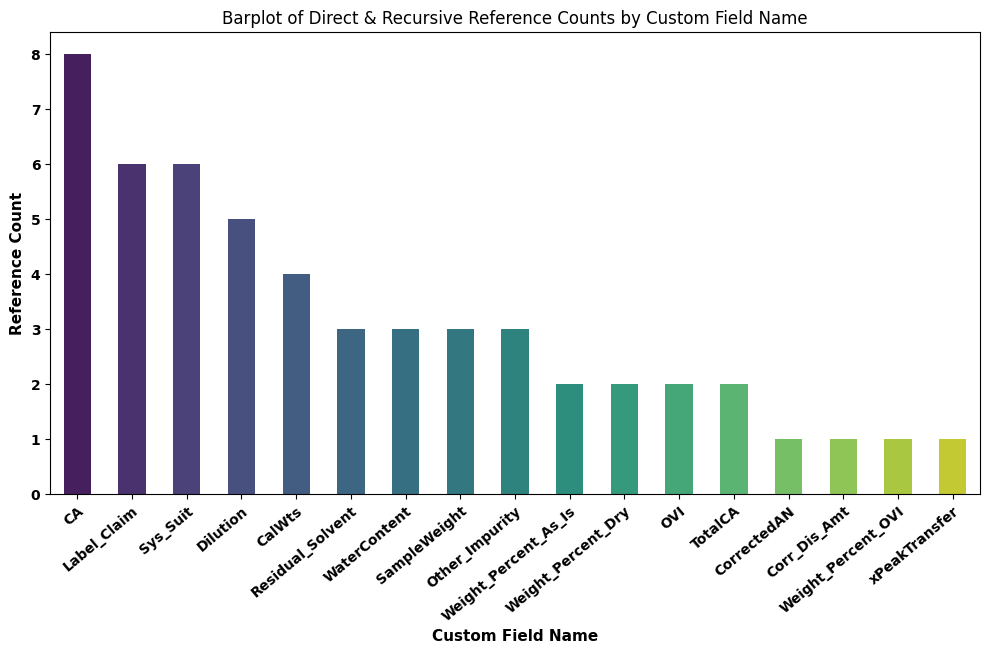

In [165]:
""" THIS IS A VISUALIZATION OF THE FIRST ANALYSIS IN STEP 5"""
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of the number of references to other custom fields
plt.figure(figsize=(12, 6))
sns.barplot(data=reference_counts_df, x='customfieldname', y='reference_count', hue='customfieldname', width=0.5, palette='viridis', legend=False)

# Set plot labels and title
plt.xlabel('Custom Field Name',fontsize=11, fontweight='bold')
plt.ylabel('Reference Count',fontsize=11, fontweight='bold')
plt.title('Barplot of Direct & Recursive Reference Counts by Custom Field Name')

# Rotate x-axis labels for better readability and set font size and weight
plt.xticks(rotation=40, fontsize=10, fontweight='bold', ha='right', rotation_mode='anchor')
# Assuming you have your y-axis limits defined
y_min, y_max = plt.ylim()

# Update y-ticks to increment by 1
plt.yticks(range(int(y_min), int(y_max) + 1), fontsize=10, fontweight='bold')


# Display the plot
plt.show()


#### **Part 2: Dependency Analysis Plot**

Objective: 

Use network analysis of weakly associated components to visualize custom field relationships

Implementation: 
- Use a recursive analysis to generate a dictionary of custom field name keys where their dictionary values correspond to their dependencies.
- using networkx module  functionality for network analysis and plotting 
- Scope of use and justifications:
  - I have reduced the size of the graphs so that over scrolling can be reduced. 
  - I will also only be using the first one as a visual demonstration of the the summary tables below it.
  
Insight: 
Will visualize the dependency of custom fields on other custom fields; where essential custom fields appear as hubs or nodes in a network


{'ABS_Assay_Diff': {'Label_Claim', 'Weight_Percent_As_Is'}, 'Abs_PctArea_Diff': set(), 'AdditionalInformation': set(), 'AR_Sensitivity': {'Dilution'}, 'AVE_CorrectedAN': {'TotalCA', 'CA', 'CorrectedAN'}, 'Avg_RT': set(), 'CA': set(), 'CalWts': {'Dilution', 'SampleWeight'}, 'CF': set(), 'Column Name': set(), 'Column Serial Number': set(), 'Column_ID': set(), 'CorrectedAN': {'TotalCA', 'CA'}, 'Corr_Dis_Amt': set(), 'Dilution': set(), 'DOE Analyst': set(), 'DOE Column': set(), 'DOE Day': set(), 'DOE Instrument': set(), 'Experiment Name': set(), 'Filter Type': set(), 'Filtrate Volume': set(), 'Filtrate Volume Units': set(), 'Initial_Test_Record': set(), 'Label_Claim': set(), 'Laboratory Name': set(), 'Level Values': set(), 'LimsSampleId': set(), 'LimsTestId': set(), 'LIMS_TRANSFER_ATTRIBUTE': {'xPeakTransfer'}, 'Notebook_ID': set(), 'Other_Impurity': set(), 'Overall_RSD_INJ': set(), 'OVI': {'Other_Impurity', 'Residual_Solvent'}, 'OVI_ppm': {'Weight_Percent_OVI'}, 'Percent_Assay_Difference'

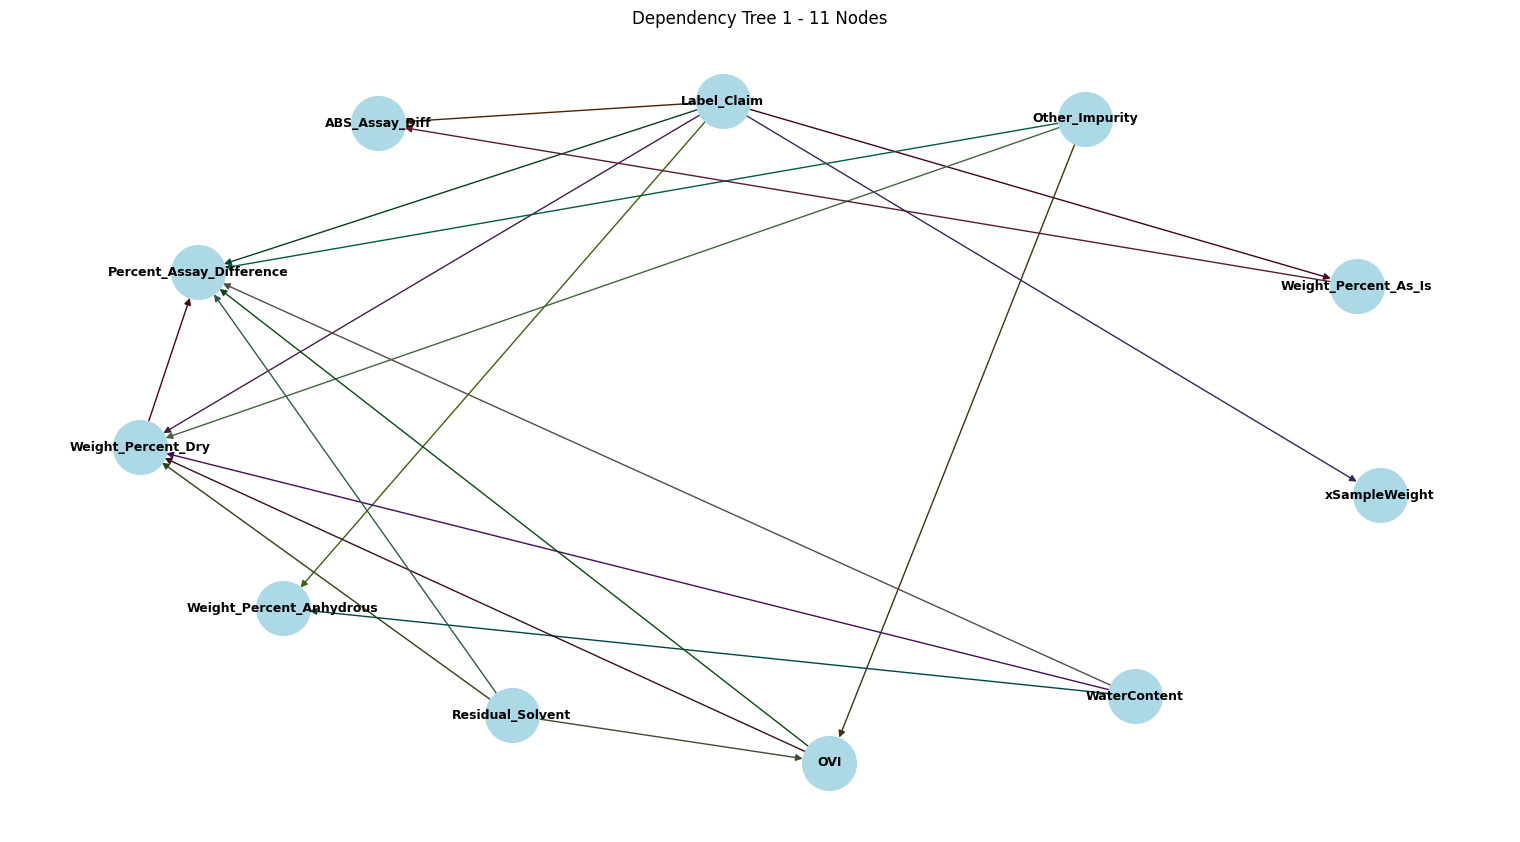

Dependency Tree 2 has 7 nodes.


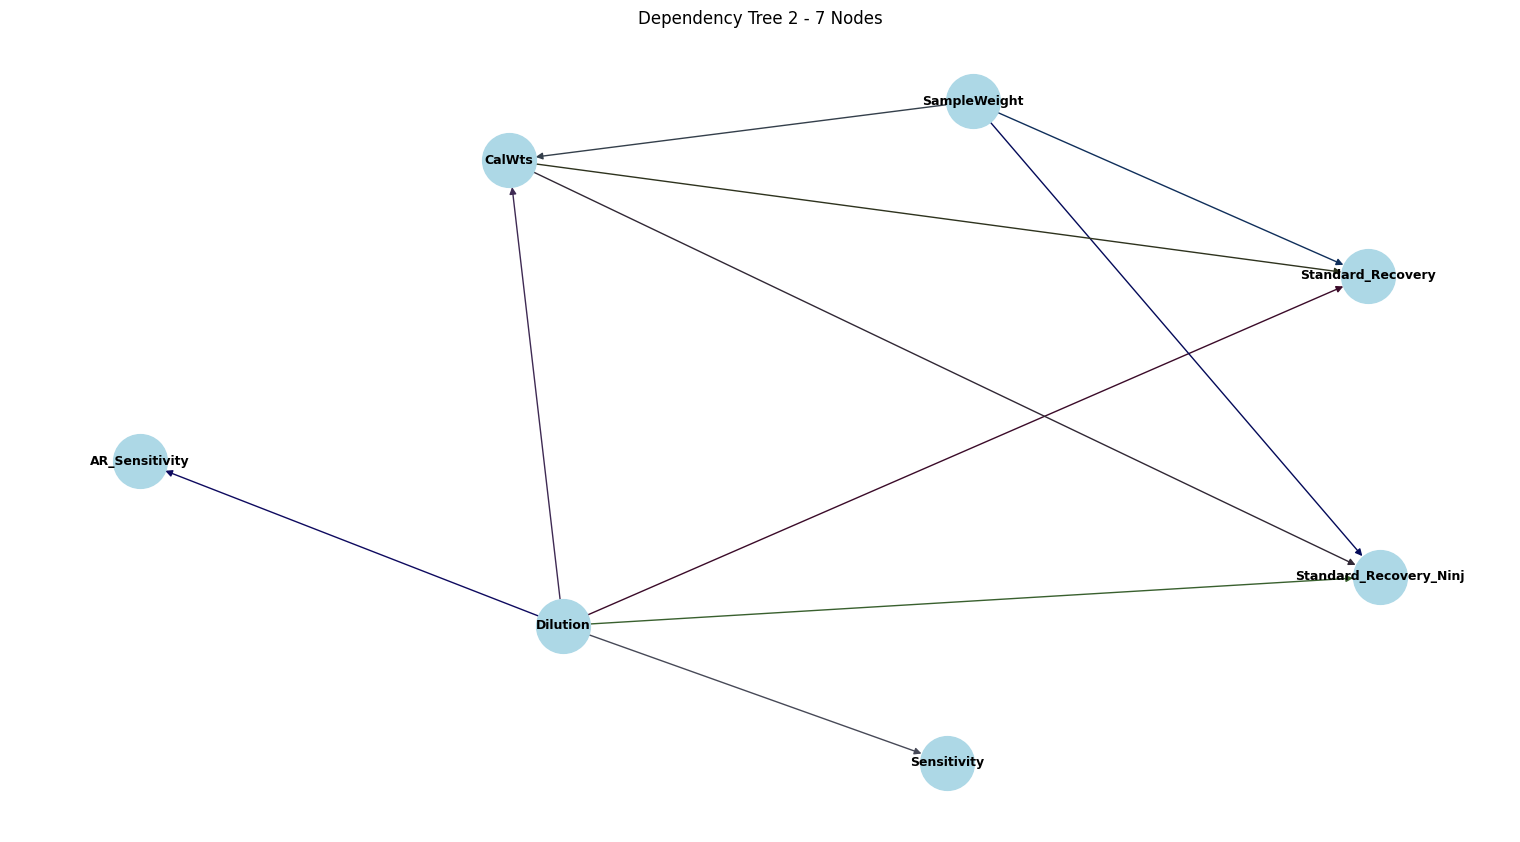

Dependency Tree 3 has 5 nodes.


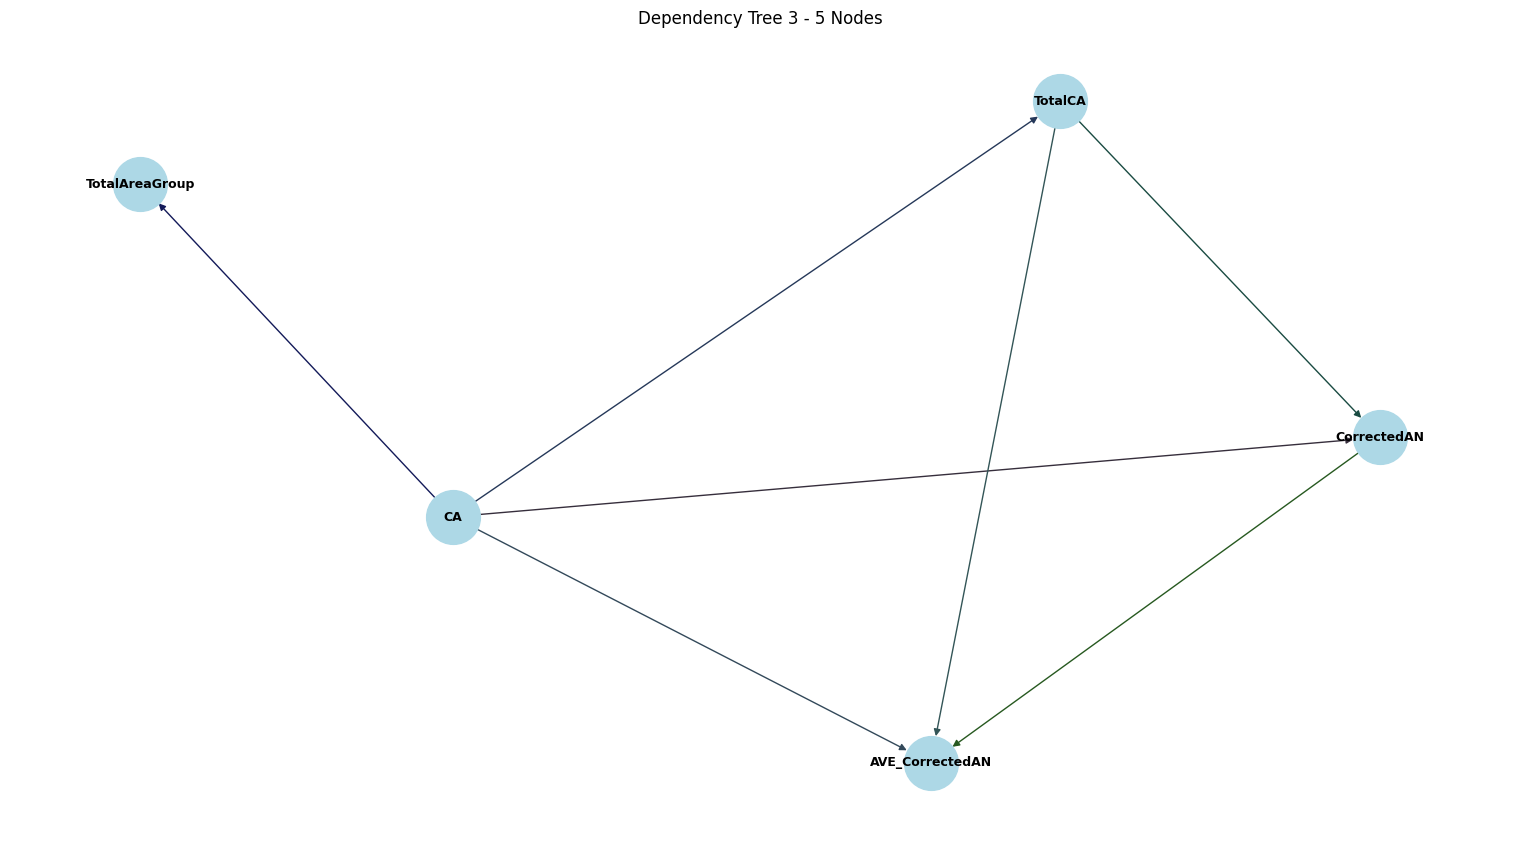

Dependency Tree 4 has 4 nodes.


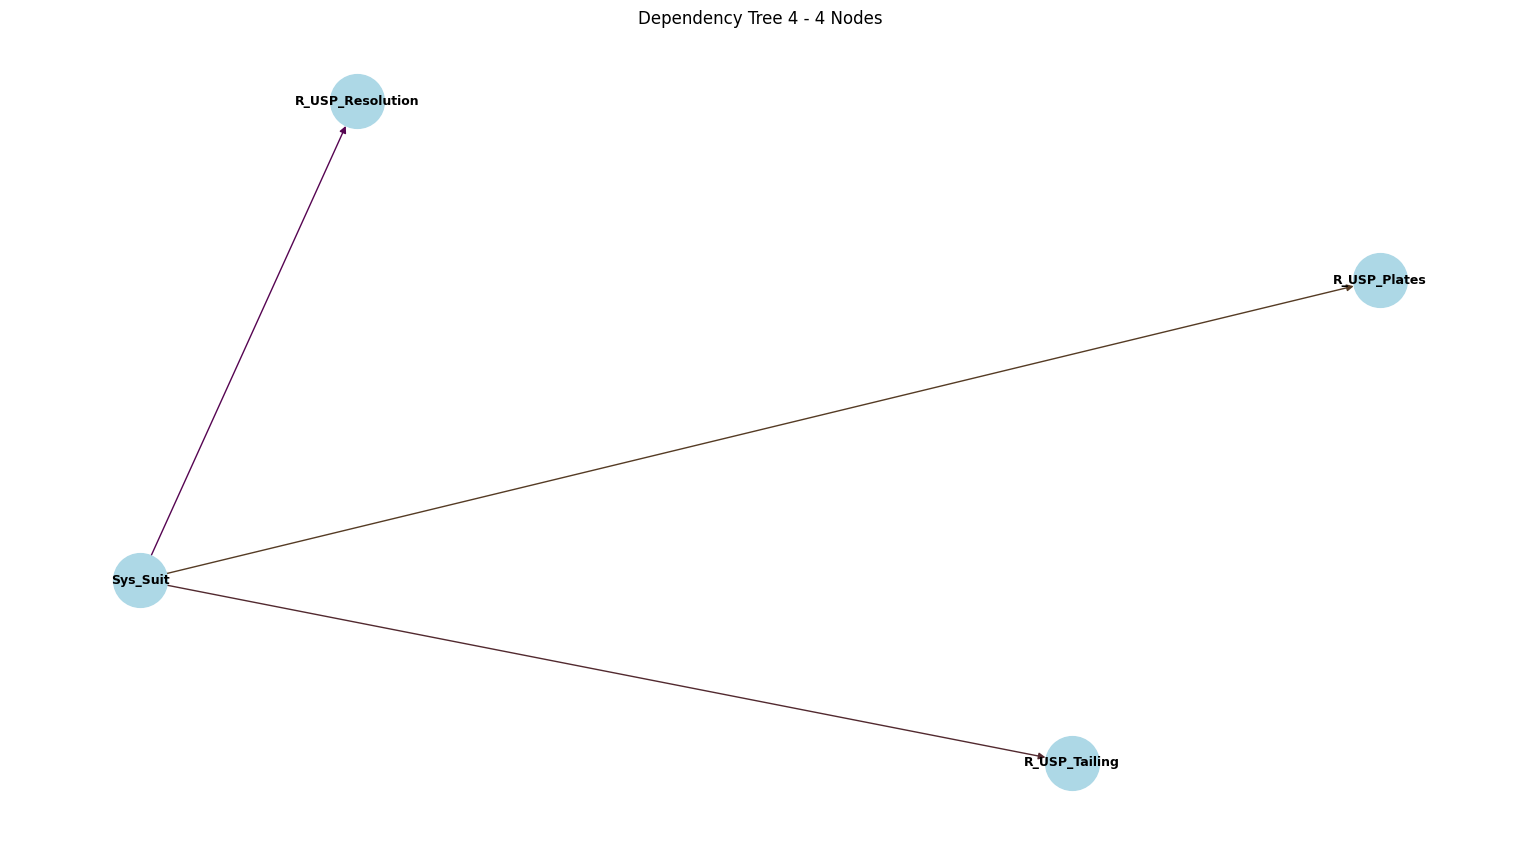

Dependency Tree 5 has 6 nodes.


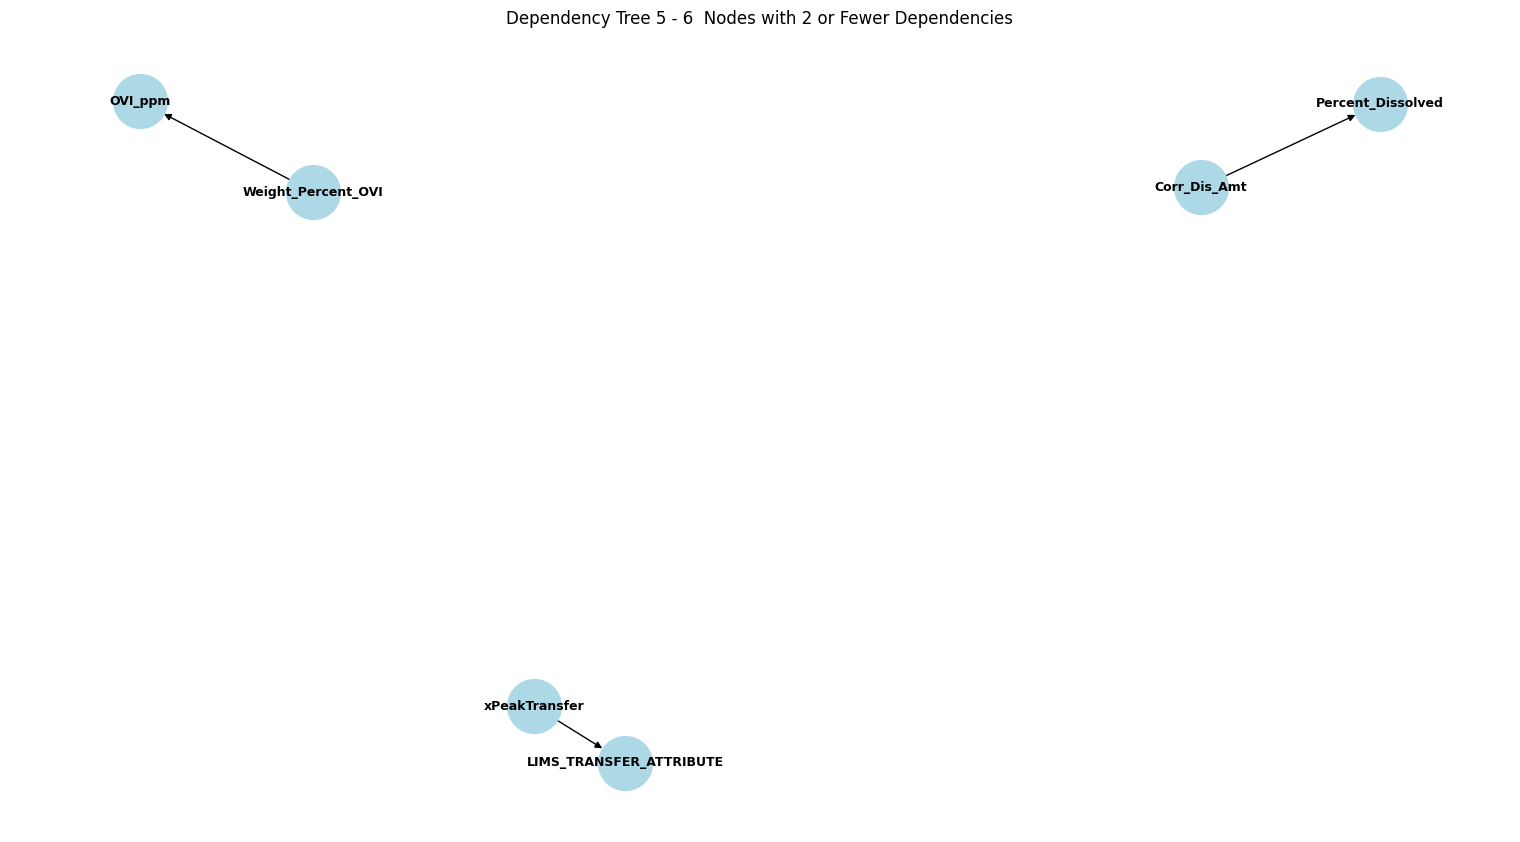

In [166]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random

"""Recursive analysis to generate a dictionary for custom fields
where the key is the custom field name and the value is a set of custom fields that the key custom field depends on."""



# Function to perform dependency analysis
def dependency_analysis(df):
    dependencies = {}

    """to simplify string matches for custom field names used in calculations, we know that all custom fields
    referenced in formulas for other custom fields do not contain spaces."""

    for _, row in df.iterrows():
        field_name = row['customfieldname']
        #print(field_name)

        formula = row['formula']

        # Extract all field names used in the formula
        fields_in_formula = rec_collect_references(formula, df)

        # Update the dependency map
        if field_name not in dependencies:
            dependencies[field_name] = set()

        for field in fields_in_formula:
            if field != field_name and field in df['customfieldname'].values:
                dependencies[field_name].add(field)

    return dependencies
# a function to generate a list of darker colors for each edge in the plot below
def generate_darker_color():
    r = random.randint(0, 100)
    g = random.randint(0, 100)
    b = random.randint(0, 100)
    return f"#{r:02x}{g:02x}{b:02x}"

"""Use of the dictionary output from the dependency analysis function to plot a dependency tree for the custom fields."""
def plot_dependency_tree(dependencies):
    G = nx.DiGraph()

    # Add edges to the graph
    for field, deps in dependencies.items():
        for dep in deps:
            G.add_edge(dep, field)  # Add an edge from dependency to the field

    # Identify weakly connected components
    components = list(nx.weakly_connected_components(G))

    # Separate nodes with 2 or fewer dependencies
    few_dependency_nodes = set()
    large_components = []

    for component in components:
        if len(component) <= 2:
            few_dependency_nodes.update(component)
        else:
            large_components.append(component)


    # Plot each remaining component separately
    for i, component in enumerate(large_components):
        subgraph = G.subgraph(component)
        
        # Adjust the layout to spread out the nodes
        plt.figure(figsize=(15, 8))
        pos = nx.spring_layout(subgraph, k=5.0, iterations=100)  # Adjust 'k' and 'iterations' for better spacing
        edge_colors = [generate_darker_color() for _ in subgraph.edges()]
        # Draw the nodes and edges with unidirectional solid lines
        nx.draw(subgraph, pos, with_labels=True, node_size=1500, node_color='lightblue', font_size=9, font_weight='bold', arrows=True, arrowstyle='-|>', edge_color= edge_colors)
        print(f"Dependency Tree {i+1} has {len(subgraph.nodes)} nodes.")
        # Set the title and show the plot
        plt.title(f"Dependency Tree {i+1} - {len(subgraph.nodes)} Nodes")
        plt.show()
  
    # Plot nodes with 2 or fewer dependencies together
    if few_dependency_nodes:
        subgraph = G.subgraph(few_dependency_nodes)
        
        # Adjust the layout to spread out the nodes
        plt.figure(figsize=(15, 8))
        pos = nx.spring_layout(subgraph, k=0.2, iterations=40)  # Adjust 'k' and 'iterations' for better spacing

        # Draw the nodes and edges with unidirectional solid lines
        nx.draw(subgraph, pos, with_labels=True, node_size=1500, node_color='lightblue', font_size=9, font_weight='bold', arrows=True, arrowstyle='-|>', edge_color='black')
        print(f"Dependency Tree {len(large_components)+1} has {len(subgraph.nodes)} nodes.")
        # Set the title and show the plot
        plt.title(f"Dependency Tree {len(large_components)+1} - {len(subgraph.nodes)}  Nodes with 2 or Fewer Dependencies")
        plt.show()
        
# Perform dependency analysis
dependencies = dependency_analysis(unique_combinations_df)
print(dependencies)

# Plot dependencies
plot_dependency_tree(dependencies)





#### **Part 3: Field Dependency Depth**

Objective: Calculate the depth of dependency for each field, i.e., how many levels deep a field's dependencies go.

Implementation: Implement a recursive function that calculates the maximum depth for each field.

Insight: Fields with greater dependency depth might be more complex and critical in the overall data structure.

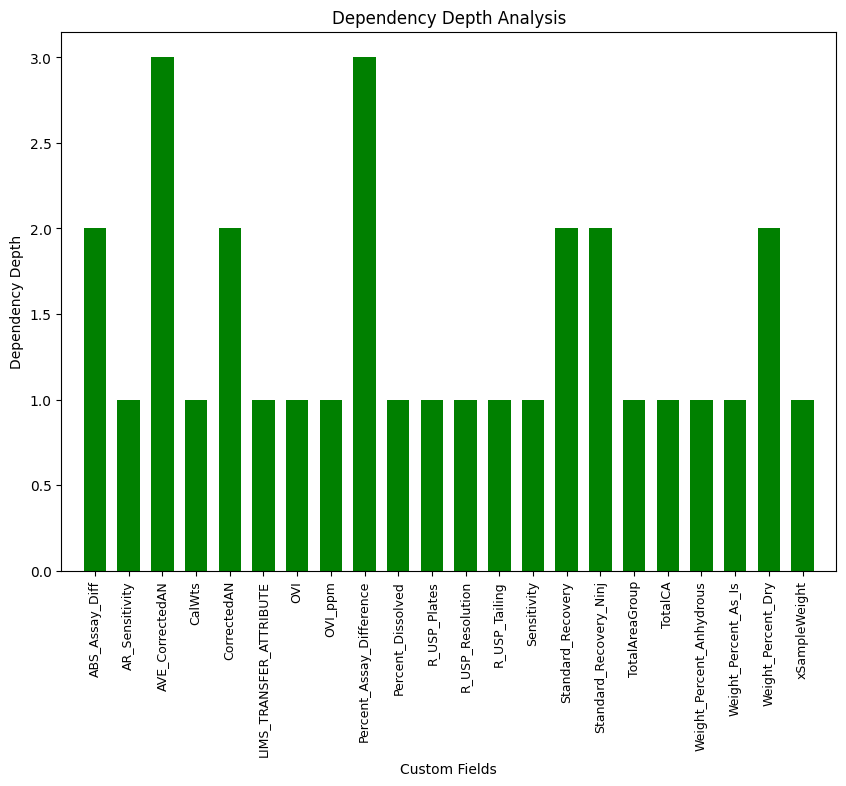

In [167]:
def calculate_dependency_depth(field, dependencies, depth=0):
    if field not in dependencies or not dependencies[field]:
        return depth
    return max(calculate_dependency_depth(dep, dependencies, depth + 1) for dep in dependencies[field])


def dependency_depth_analysis(dependencies):
    depth_dict = {field: calculate_dependency_depth(field, dependencies) for field in dependencies}
    
    # Filter out fields with a dependency depth of 0
    filtered_depth_dict = {field: depth for field, depth in depth_dict.items() if depth > 0}

    # Plot the dependency depth
    plt.figure(figsize=(10, 7))
    
    fields = list(filtered_depth_dict.keys())
    spacing = 1.2  # Adjust this value to increase the spread
    positions = [i * spacing for i in range(len(fields))]
    
    plt.bar(positions, filtered_depth_dict.values(), color='green')
    
    # Set the ticks and labels
    plt.xticks(positions, fields, rotation=90, fontsize=9)
    
    # Adjust x-axis limits to fit the bars more tightly
    plt.xlim(-spacing, max(positions) + spacing)
    plt.xlabel("Custom Fields")
    plt.ylabel("Dependency Depth")
    plt.title("Dependency Depth Analysis")
    plt.show()
dependency_depth_analysis(dependencies)


#### **Part 4: Cluster Analysis of Dependencies**

Objective: Identify clusters of fields that are tightly connected through dependencies.

Implementation: Use graph clustering techniques (like connected components or community detection) to identify groups of interrelated fields.

Insight: This can reveal natural groupings of fields that may represent coherent sub-systems or modules within your dataset.

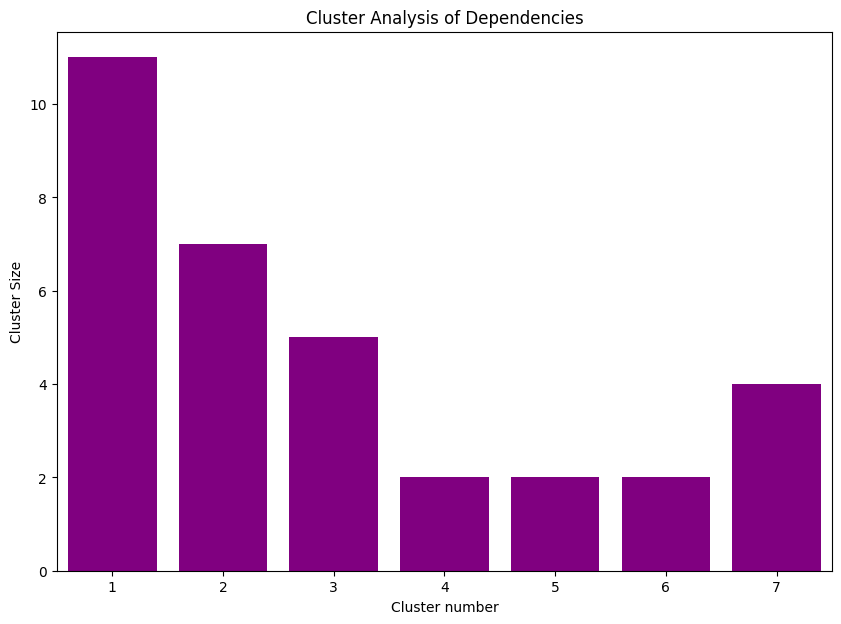

,Dependencies
Cluster 1,"Label_Claim, Residual_Solvent, Weight_Percent_Anhydrous, Other_Impurity, xSampleWeight, WaterContent, ABS_Assay_Diff, OVI, Percent_Assay_Difference, Weight_Percent_Dry, Weight_Percent_As_Is"
Cluster 2,"AR_Sensitivity, CalWts, SampleWeight, Standard_Recovery, Sensitivity, Dilution, Standard_Recovery_Ninj"
Cluster 3,"AVE_CorrectedAN, CA, TotalCA, CorrectedAN, TotalAreaGroup"
Cluster 4,"LIMS_TRANSFER_ATTRIBUTE, xPeakTransfer"
Cluster 5,"Weight_Percent_OVI, OVI_ppm"
Cluster 6,"Corr_Dis_Amt, Percent_Dissolved"
Cluster 7,"R_USP_Tailing, R_USP_Plates, R_USP_Resolution, Sys_Suit"


In [168]:
def cluster_dependency_analysis(dependencies):
    G = nx.DiGraph()
    for field, deps in dependencies.items():
        for dep in deps:
            G.add_edge(dep, field)

    clusters = list(nx.weakly_connected_components(G))
    cluster_sizes = [len(cluster) for cluster in clusters]

    
    # Plot the clusters
    plt.figure(figsize=(10, 7))  
    
    # Create x-tick positions starting from 1
    x_ticks = range(1, len(cluster_sizes) + 1)
    
    # Plot the bar chart with the adjusted x-ticks
    plt.bar(x_ticks, cluster_sizes, color='purple')
    
    # Set the x-ticks and labels
    plt.xticks(x_ticks, [str(i) for i in x_ticks])
    
    # Adjust x-axis limits to fit the bars more tightly
    plt.xlim(0.5, len(cluster_sizes) + 0.5)
    
    plt.xlabel("Cluster number")
    plt.ylabel("Cluster Size")
    plt.title("Cluster Analysis of Dependencies")
    plt.show()
    
    # Create a dictionary for the DataFrame
    cluster_dict = {f'Cluster {i+1}': ', '.join(cluster) for i, cluster in enumerate(clusters)}
    
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame.from_dict(cluster_dict, orient='index', columns=['Dependencies'])
    return df


edaf(cluster_dependency_analysis(dependencies)).table_format()  


#### **Outputting tables to html**
**Note: it is commented out to prevent outputting to file during grading**

In [174]:
# Convert DataFrames to HTML, commenting out to prevent overwriting the file
# html_output = f"""
# <html>
# <head><title>Step 7 -Part4: Cluster Analysis Summary</title></head>
# <body>
# <h1>Cluster Analysis Summary</h1>
# <h2>Custom Fields with Multiple Formulas</h2>
# {edaf(cluster_dependency_analysis(dependencies)).table_format().to_html()}
# </body>
# </html>
# """

# # Write the HTML content to a file
# with open('ABaghai_DS200_Final_Stp_7prt4.html', 'w') as f:
#     f.write(html_output)

#### **Part 5: Field Importance Based on Network Centrality**

Objective: Use network centrality measures, degree centrality, to identify key fields in the dependency network.

Implementation: Calculate centrality metrics using networkx and rank fields accordingly.

Insight: Fields with high centrality may play crucial roles as hubs or intermediaries in the dependency structure.

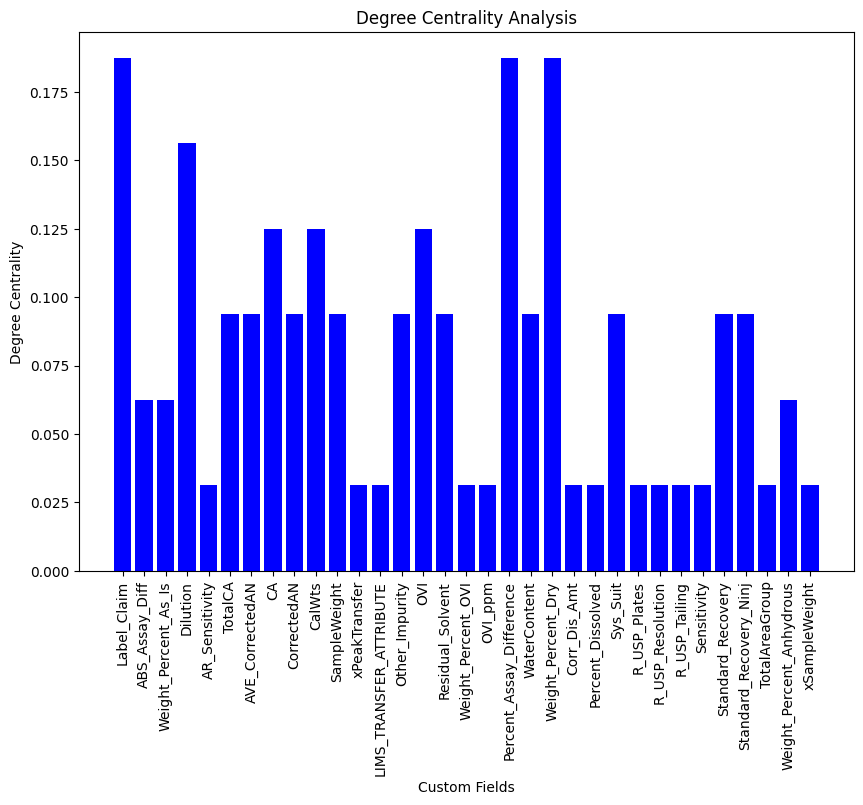

In [175]:
"""CENTRALITY ANALYSIS: this analysis will determine the importance of a custom field in the context of the entire dataset.
The analysis will rely on the networkx library to calculate the degree centrality of each custom field."""
def centrality_analysis(dependencies):
    G = nx.DiGraph()
    for field, deps in dependencies.items():
        for dep in deps:
            G.add_edge(dep, field)

    degree_centrality = nx.degree_centrality(G)

    # Plot degree centrality
    plt.figure(figsize=(10, 7))
    plt.bar(degree_centrality.keys(), degree_centrality.values(), color='blue')
    plt.xticks(rotation=90)
    plt.xlabel("Custom Fields")
    plt.ylabel("Degree Centrality")
    plt.title("Degree Centrality Analysis")
    plt.show()


centrality_analysis(dependencies)
